# Multiclass classification

In [1]:
import sklearn

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.datasets import fetch_openml

In [2]:
def plot_digits(instances, images_per_row=10, filename=None, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.get_cmap('binary_r'), **options)
    plt.axis("off")
    if filename != None:
        plt.savefig(filename);

In [3]:
def load_mnist():
    """ Load MNIST dataset from skilean datasets
    Args:
    Returns:
        X (np.array): MNIST features
        y (np.array): MINST labels
    """
    
    mnist = fetch_openml('mnist_784', version=1)
    mnist.keys()
    X, y = mnist["data"], mnist["target"]
    
    # cast labels to int
    y = y.astype(np.uint8)
    return X, y

X, y = load_mnist()

/Users/cmedina/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


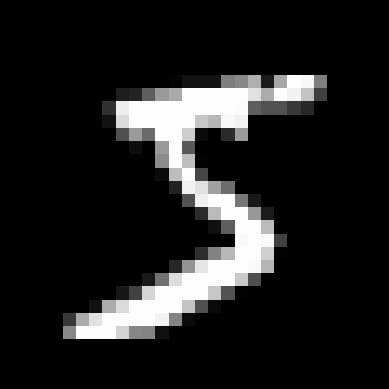

In [4]:
# plot a sample of the dataset

some_digit = X.loc[0,:].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.get_cmap('binary_r'), vmin=0, vmax=255)
plt.axis("off");

# Split Train Test subsets

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Use a linear classification algorithm with Multiclass

# OvA
- Sklearn detects a multiclass dataset and applies OvA strategy under the hood

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

/Users/cmedina/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [7]:
# check what strategy was used
sgd_clf_scores = sgd_clf.decision_function([some_digit])

/Users/cmedina/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [8]:
np.argmax(sgd_clf_scores)

5

In [9]:
sgd_clf_scores

array([[-6049581.97985829, -6138036.45541781, -3886281.38604605,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [10]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)

svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

/Users/cmedina/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [11]:
# review scores svm
svm_clf_scores = svm_clf.decision_function([some_digit])
svm_clf_scores

/Users/cmedina/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [12]:
# look for highest score
np.argmax(svm_clf_scores)

5

In [13]:
# get classifier classes
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [14]:
# lookup predicted class
svm_clf.classes_[np.argmax(svm_clf_scores)]

5

# OvO

In [15]:
from sklearn.multiclass import OneVsOneClassifier

# create instance of classifier 
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
#train
ovo_clf.fit(X_train[:1000], y_train[:1000])
ovo_clf.predict([some_digit])

/Users/cmedina/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [16]:
# check number of classifiers
len(ovo_clf.estimators_)

45

# Performance measurement

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import time

start = time.time()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# train over complete dataset -> 8.29 Min.(in my laptop)
#cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# train over a subset of the dataset
sgd_clf_scores = cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv=3, scoring="accuracy")

print('Trainning completed in: {0} Min.'.format(round((time.time()-start)/60,2)))
sgd_clf_scores

Trainning completed in: 0.05 Min.


array([0.84431138, 0.81381381, 0.77177177])

In [18]:
# get predicted data from CV trainning
# and leave out trainning data untouched
from sklearn.model_selection import cross_val_predict
start = time.time()

# # train over complete dataset -> 8.67 Min.
# # train over complete dataset -> 7m 19s.
# # Trainning completed in: 11.8 Min. 8/2/2024 M2 LOW POWER MODE :( 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# train over a subset
#y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:6000], y_train[:6000], cv=3)
print('Trainning completed in: {0} Min.'.format(round((time.time()-start)/60,2)))

Trainning completed in: 11.8 Min.


In [19]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

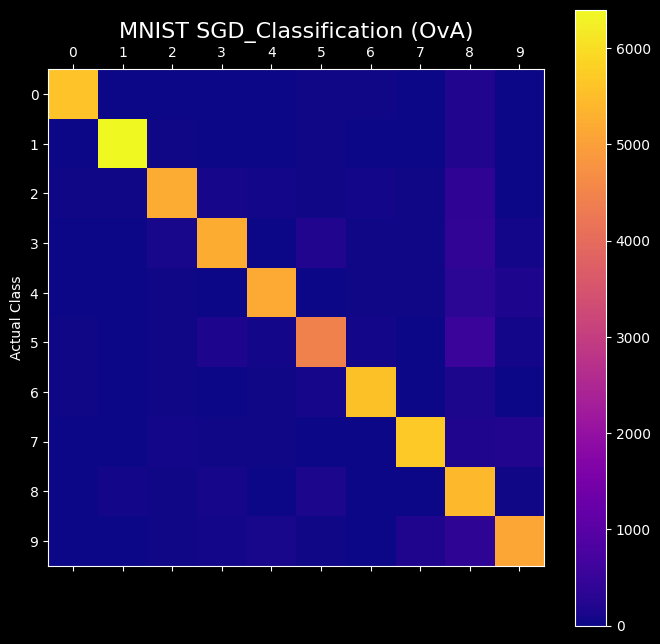

In [20]:

# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix,filename=None):
    """If you prefer color and a colorbar
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap='plasma')
    fig.colorbar(cax)
    ax.set_title('MNIST SGD_Classification (OvA)',fontsize=16)
    ax.xaxis.set_ticks(np.arange(0, 10, 1))
    ax.yaxis.set_ticks(np.arange(0, 10, 1))
    ax.set_ylabel('Actual Class')
    if filename != None:
        plt.savefig(filename)
    plt.show()
    
plot_confusion_matrix(conf_mx,filename='conf_matrix.png')

# Focus on the errors in the Conf. Matrix

In [21]:
# get error rates to avoid uneven class distribution
# and compare absolute number of errors (abundant classes would look unfairly bad)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# classification for 
norm_conf_mx[0,:]

array([9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
       1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
       3.79875063e-02, 1.68833361e-04])

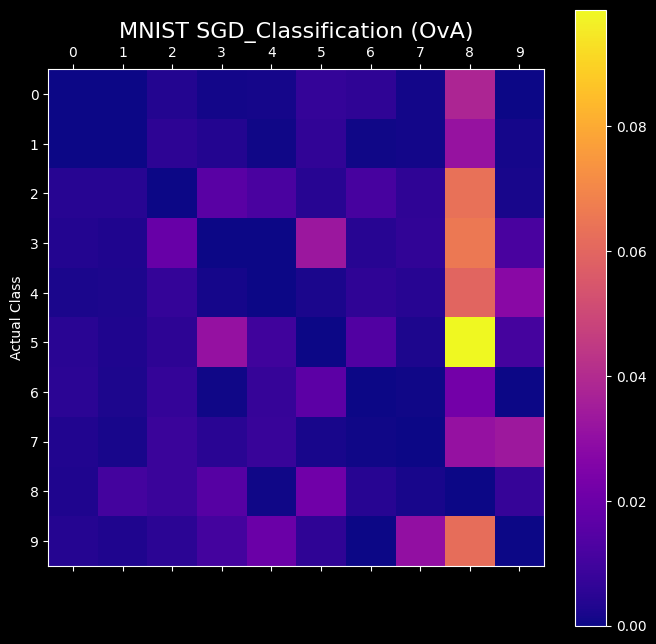

In [24]:
# remove data from matrix diagonal
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx,filename='conf_matrix_errors.png')

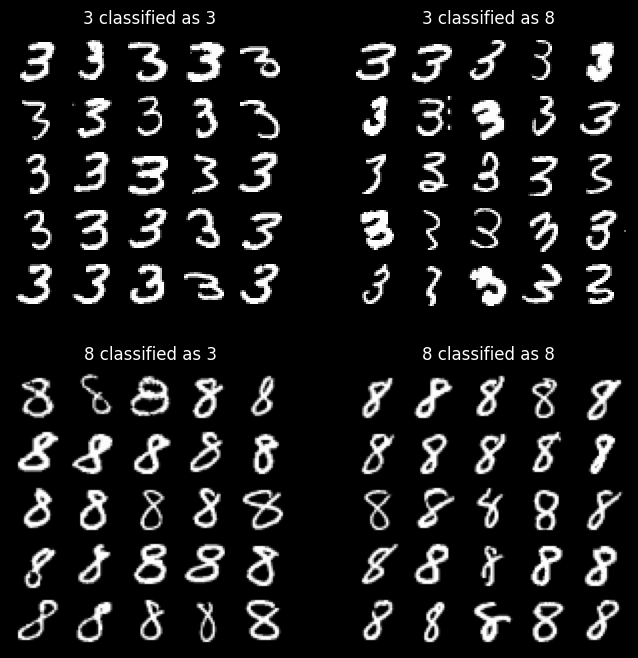

In [27]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221).title.set_text(f'{cl_a} classified as {cl_a}'); plot_digits(X_aa[:25].to_numpy(), images_per_row=5)
plt.subplot(222).title.set_text(f'{cl_a} classified as {cl_b}'); plot_digits(X_ab[:25].to_numpy(), images_per_row=5)
plt.subplot(223).title.set_text(f'{cl_b} classified as {cl_a}'); plot_digits(X_ba[:25].to_numpy(), images_per_row=5)
plt.subplot(224).title.set_text(f'{cl_b} classified as {cl_b}'); plot_digits(X_bb[:25].to_numpy(), images_per_row=5)
plt.savefig('errors_mnist.png');
plt.show()
